Hourly Forecast RMSE (2023–2024): 0.51


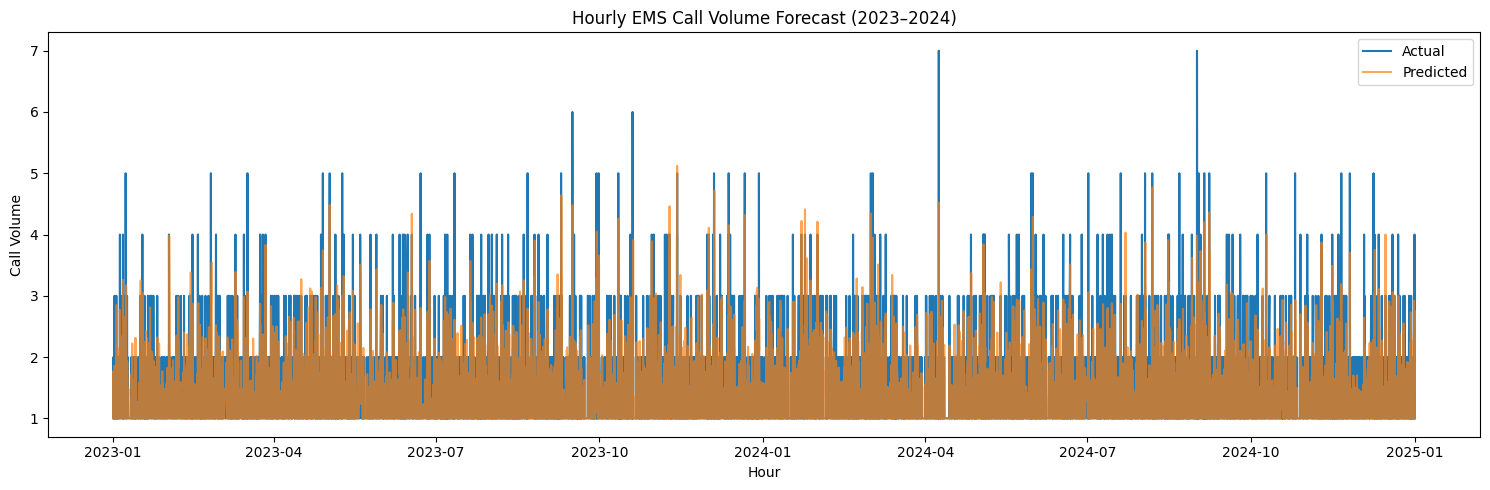

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# --- 1. Load and Filter Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])

# Keep only full years 2017–2024
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]

# --- 2. Aggregate to Hourly ---
df['hour'] = df['CallDateTime'].dt.floor('h')
hourly = df.groupby('hour').size().reset_index(name='call_volume')

# --- 3. Time-Based Features ---
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.dayofweek
hourly['week_of_year'] = hourly['hour'].dt.isocalendar().week.astype(int)
hourly['month'] = hourly['hour'].dt.month
hourly['year'] = hourly['hour'].dt.year

# --- 4. Lag & Rolling Features ---
for lag in [1, 24, 48, 168]:
    hourly[f'lag_{lag}'] = hourly['call_volume'].shift(lag)

hourly['rolling_3h'] = hourly['call_volume'].rolling(3).mean()
hourly['rolling_24h'] = hourly['call_volume'].rolling(24).mean()
hourly['rolling_7d'] = hourly['call_volume'].rolling(24*7).mean()

hourly.dropna(inplace=True)

# --- 5. Split into Train/Test (no shuffle) ---
features = [
    'hour_of_day', 'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_24', 'lag_48', 'lag_168',
    'rolling_3h', 'rolling_24h', 'rolling_7d'
]

train = hourly[hourly['hour'] < '2023-01-01']
test = hourly[hourly['hour'] >= '2023-01-01']

X_train = train[features]
y_train = train['call_volume']
X_test = test[features]
y_test = test['call_volume']

# --- 6. Train Model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 7. Predict & Evaluate ---
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Hourly Forecast RMSE (2023–2024): {rmse:.2f}")

# --- 8. Plot Results ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'], y_test.values, label='Actual')
plt.plot(test['hour'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Volume Forecast (2023–2024)')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


In [ ]:





########## BELOW IS TRYING TO PREDICT BY 3 HOUR TIME SEGMENT ###############







Hourly Forecast RMSE (2023–2024): 0.50


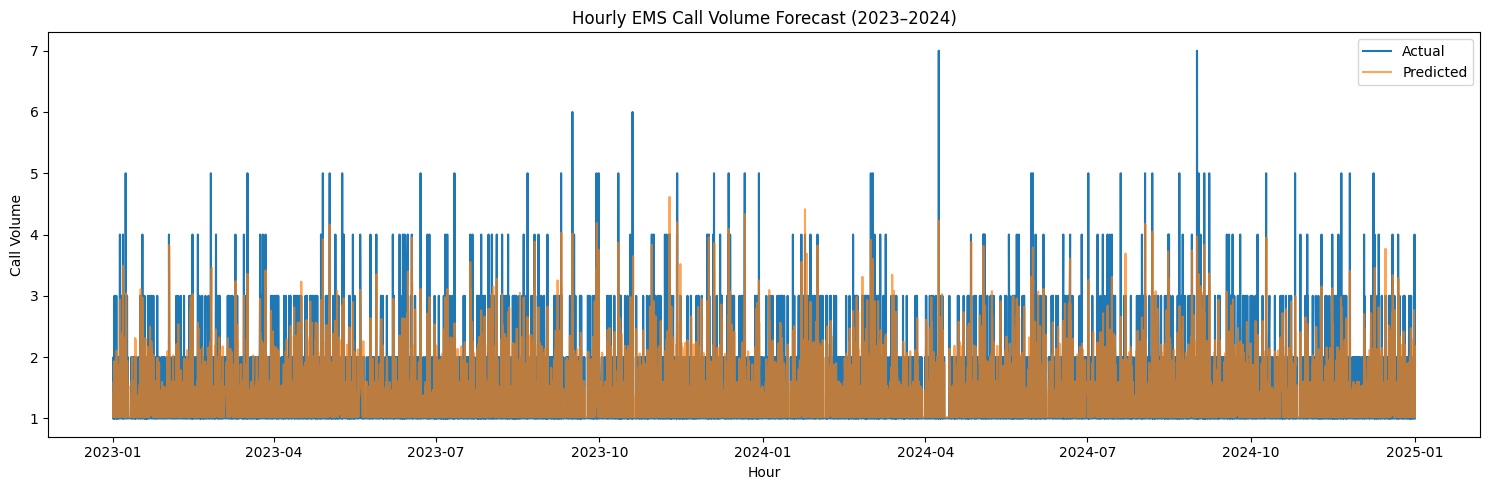

In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05)
model.fit(X_train, y_train)
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Hourly Forecast RMSE (2023–2024): {rmse:.2f}")

# --- 8. Plot Results ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'], y_test.values, label='Actual')
plt.plot(test['hour'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Volume Forecast (2023–2024)')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

Improved RMSE (log-transformed): 0.46


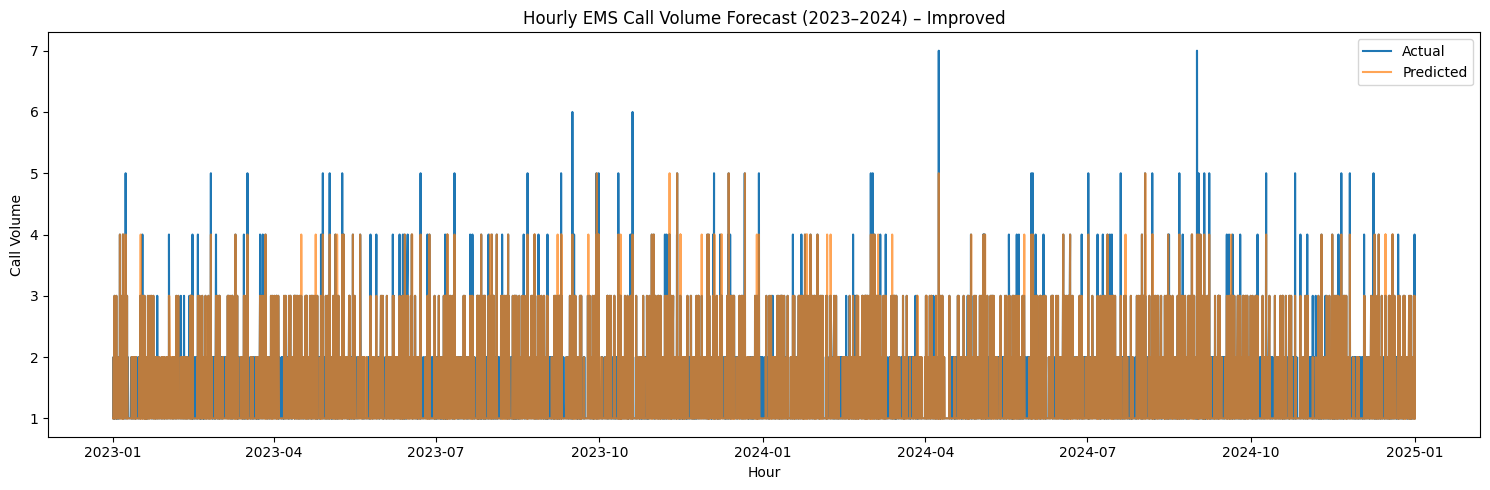

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load and Filter Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]

# --- 2. Aggregate to Hourly ---
df['hour'] = df['CallDateTime'].dt.floor('h')
hourly = df.groupby('hour').size().reset_index(name='call_volume')

# --- 3. Basic Time Features ---
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.dayofweek
hourly['week_of_year'] = hourly['hour'].dt.isocalendar().week.astype(int)
hourly['month'] = hourly['hour'].dt.month
hourly['year'] = hourly['hour'].dt.year

# --- 4. Advanced Lag + Rolling ---
for lag in [1, 24, 48, 168]:
    hourly[f'lag_{lag}'] = hourly['call_volume'].shift(lag)

hourly['rolling_3h'] = hourly['call_volume'].rolling(3).mean()
hourly['rolling_24h'] = hourly['call_volume'].rolling(24).mean()
hourly['rolling_7d'] = hourly['call_volume'].rolling(24*7).mean()

# Same hour last week
hourly['same_hour_last_week'] = hourly['call_volume'].shift(24*7)

# Spike flag
rolling_std = hourly['call_volume'].rolling(24*7).std()
hourly['is_spike'] = (hourly['call_volume'] > hourly['rolling_7d'] + rolling_std).astype(int)

# Holiday + Weekend
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=hourly['hour'].min(), end=hourly['hour'].max())
hourly['is_holiday'] = hourly['hour'].dt.normalize().isin(holidays).astype(int)
hourly['is_weekend'] = hourly['day_of_week'].isin([5, 6]).astype(int)

# --- 5. Drop NA Rows from lag/rolling ---
hourly.dropna(inplace=True)

# --- 6. Feature Set ---
features = [
    'hour_of_day', 'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_24', 'lag_48', 'lag_168',
    'rolling_3h', 'rolling_24h', 'rolling_7d',
    'same_hour_last_week', 'is_spike', 'is_holiday', 'is_weekend'
]

# --- 7. Train/Test Split (temporal) ---
train = hourly[hourly['hour'] < '2023-01-01']
test = hourly[hourly['hour'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]

# Log transform target
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 8. Train Model ---
model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# --- 9. Predict and Evaluate ---
preds_log = model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Improved RMSE (log-transformed): {rmse:.2f}")

# --- 10. Plot Actual vs Predicted ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'], y_test_actual, label='Actual')
plt.plot(test['hour'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Volume Forecast (2023–2024) – Improved')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


RMSE with Trend Feature: 0.47


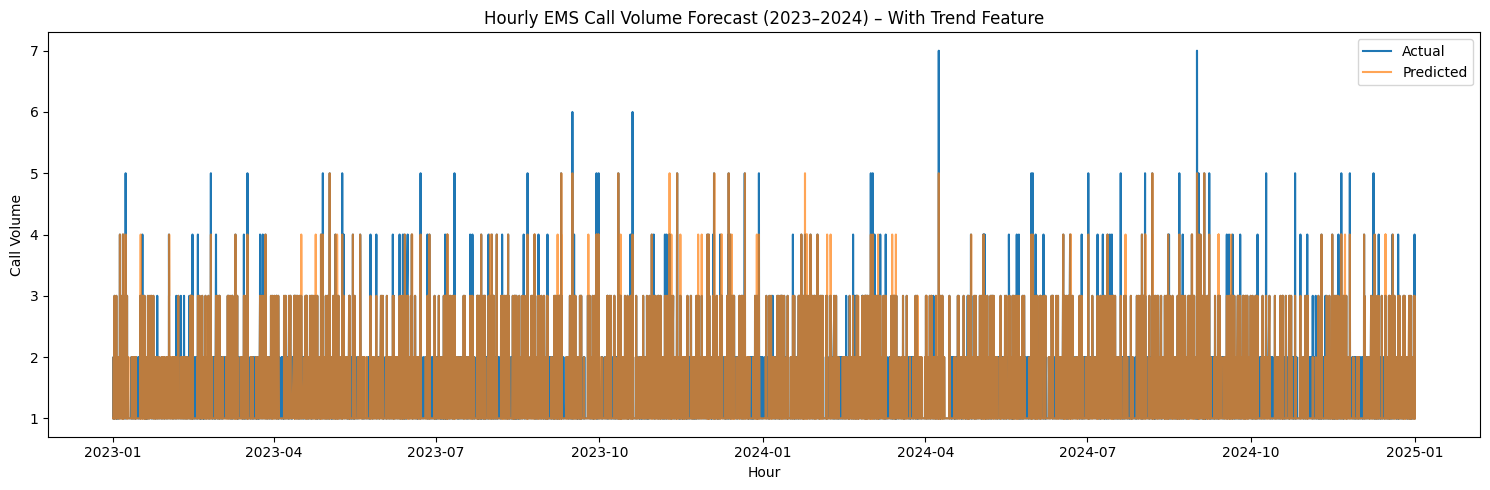

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load and Filter Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]

# --- 2. Aggregate to Hourly ---
df['hour'] = df['CallDateTime'].dt.floor('h')
hourly = df.groupby('hour').size().reset_index(name='call_volume')

# --- 3. Time Features ---
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.dayofweek
hourly['week_of_year'] = hourly['hour'].dt.isocalendar().week.astype(int)
hourly['month'] = hourly['hour'].dt.month
hourly['year'] = hourly['hour'].dt.year

# --- 4. Lag & Rolling Features ---
for lag in [1, 24, 48, 168]:
    hourly[f'lag_{lag}'] = hourly['call_volume'].shift(lag)

hourly['rolling_3h'] = hourly['call_volume'].rolling(3).mean()
hourly['rolling_24h'] = hourly['call_volume'].rolling(24).mean()
hourly['rolling_7d'] = hourly['call_volume'].rolling(24*7).mean()
hourly['same_hour_last_week'] = hourly['call_volume'].shift(24*7)

# --- 5. Trend Feature (NEW) ---
hourly['trend_6h'] = hourly['rolling_3h'] - hourly['rolling_24h']

# --- 6. Spikes, Holidays, Weekends ---
rolling_std = hourly['call_volume'].rolling(24*7).std()
hourly['is_spike'] = (hourly['call_volume'] > hourly['rolling_7d'] + rolling_std).astype(int)

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=hourly['hour'].min(), end=hourly['hour'].max())
hourly['is_holiday'] = hourly['hour'].dt.normalize().isin(holidays).astype(int)
hourly['is_weekend'] = hourly['day_of_week'].isin([5, 6]).astype(int)

# --- 7. Drop NAs ---
hourly.dropna(inplace=True)

# --- 8. Features & Target ---
features = [
    'hour_of_day', 'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_24', 'lag_48', 'lag_168',
    'rolling_3h', 'rolling_24h', 'rolling_7d',
    'same_hour_last_week', 'trend_6h',
    'is_spike', 'is_holiday', 'is_weekend'
]

train = hourly[hourly['hour'] < '2023-01-01']
test = hourly[hourly['hour'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]

# Log-transform target
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 9. Train Model ---
model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# --- 10. Predict ---
preds_log = model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"RMSE with Trend Feature: {rmse:.2f}")

# --- 11. Plot Results ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'], y_test_actual, label='Actual')
plt.plot(test['hour'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Volume Forecast (2023–2024) – With Trend Feature')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


RMSE with Trend Feature: 0.47


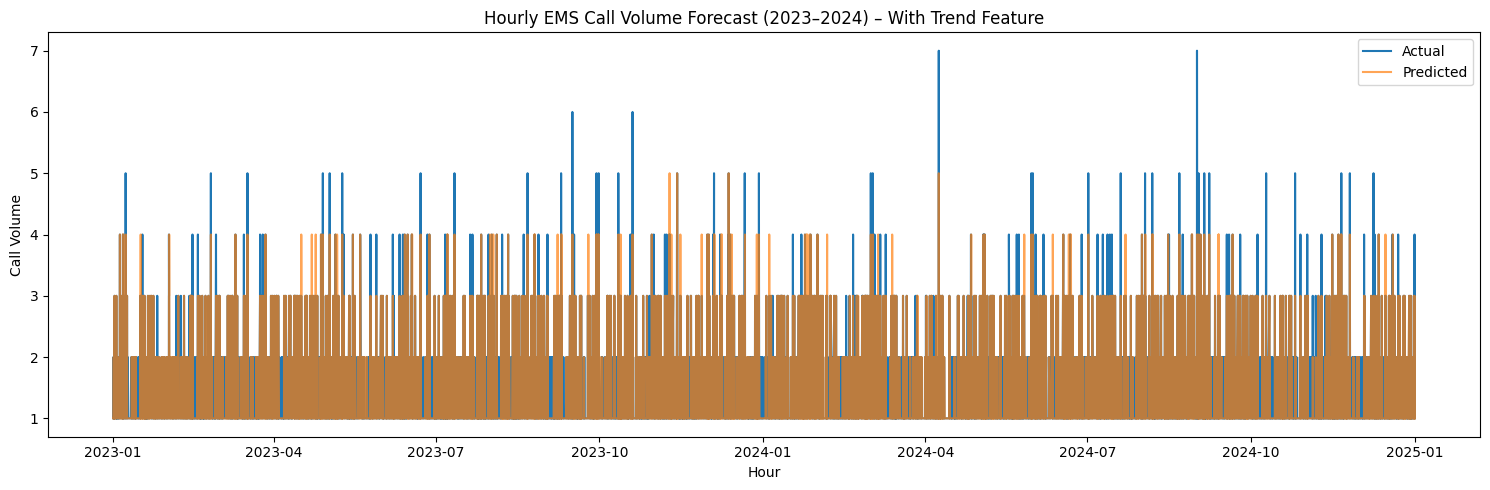

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

param_grid = {
    'max_iter': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 10, 14],
    'min_samples_leaf': [10, 20, 50],
    'l2_regularization': [0.0, 0.1, 1.0],
    'loss': ['poisson']
}

model = HistGradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best RMSE (log-space):", -grid.best_score_)

best_model = grid.best_estimator_
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"RMSE with Trend Feature: {rmse:.2f}")

# --- 11. Plot Results ---
plt.figure(figsize=(15, 5))
plt.plot(test['hour'], y_test_actual, label='Actual')
plt.plot(test['hour'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Hourly EMS Call Volume Forecast (2023–2024) – With Trend Feature')
plt.xlabel('Hour')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()